# 环境测试

In [1]:
import tensorflow  as tf
# 使用RTX显卡时，似乎必须要制定限定显存，不然会报错
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

返回运行时可见的物理设备列表，默认情况下，所有发现的CPU和GPU设备都被视为可见的。

In [3]:
tf.config.experimental.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

查看GPU设备信息

In [4]:
!nvidia-smi

Wed May 13 22:02:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   47C    P8    20W / 175W |    165MiB /  7979MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

检查GPU是否可用

In [5]:
tf.test.is_gpu_available()

True

查看GPU是否可用

In [7]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# 启用设备放置日志记录将导致打印任何张量分配或操作
tf.debugging.set_log_device_placement(True)

In [6]:
tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)

VirtualDeviceConfiguration(memory_limit=1024)

# 数据处理

## 数据载入

+ CIFAR-10数据集

&emsp;&emsp;CIFAR-10数据集是一个用于识别普适物体的小型数据集，它一共包含10个类别的RGB彩色图片：飞机（airplane）、汽车（automobile）、鸟类（bird）、猫（cat）、鹿（deer）、狗（dog）、蛙类（frog）、马（horse）、船（ship）和卡车（truck）。图片的尺寸为32x32，该数据集一共有50000张训练图片和10000张测试图片。

&emsp;&emsp;1个10000x3072大小的uint8s数组。数组的每行存储1张32*32的图像,第1个1024包含红色通道值，下1个包含绿色，最后的1024包含蓝色。图像存储以行顺序为主，所以数组的前32列为图像第1行的红色通道值。

In [2]:
import pickle
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
class CIFAR10(object):
    
    def __init__(self,path='/home/wcjb/Code/Dataset/cifar-10-batches-py/'):
        self.trainpath = [os.path.join(path,'data_batch_'+str(i+1)) for i in range(5)]
        self.testpath = [os.path.join(path,'test_batch')]
    
    def unpickle(self,file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding = 'iso-8859-1') # 
        return dict
    
    def load_batch(self,file):
        
        with open(file, 'rb')as f:
            datadict = self.unpickle(file)
            data = datadict['data']
            label = datadict['labels']
            data = data.reshape(10000, 3, 32, 32)
            label = np.array(label)
            return data,label
        
    def toimg(self,data):
        img = []
        for i in range(data.shape[0]):
            imgs = data[i - 1]
            r = imgs[0]
            g = imgs[1]
            b = imgs[2]
            R = Image.fromarray(r)
            G = Image.fromarray(g)
            B = Image.fromarray(b)
            
            img.append(Image.merge("RGB",(R,G,B)))
        return img
            
        
    def cif2img(self):
        
        train_img,test_img = [],[]
    
        for tp in tqdm(self.trainpath,desc='Train-img'):
            
            data,label = self.load_batch(tp)
            train_img.append(self.toimg(data))
            
        for tp in tqdm(self.testpath,desc='Test-img '):
            
            data,label = self.load_batch(tp)
            test_img.append(self.toimg(data))
            
            
        return train_img,test_img
        
    def cif2data(self):
        
        x_train,y_train,x_test,y_test = [],[],[],[]
        for tp in tqdm(self.trainpath,desc='Train'):
            data,label = self.load_batch(tp)
            x_train.append(data)
            y_train.append(label)
        for tp in tqdm(self.testpath,desc='Test '):
            data,label = self.load_batch(tp)
            x_test.append(data)
            y_test.append(label)
        x_train,y_train = np.array(x_train).reshape(-1,3,32,32),np.array(y_train).reshape(-1,)
        x_test,y_test = np.array(x_test).reshape(-1,3,32,32),np.array(y_test).reshape(-1,)
        x_train,x_test = np.rollaxis(x_train, 1,4),np.rollaxis(x_test,1, 4)
        
        return x_train,y_train,x_test,y_test

In [3]:
cif = CIFAR10()
# 将CIFAR10数据集加载为图片数据
train_img,test_img = cif.cif2img()
# 将将CIFAR10数据集加载为多维数据用于训练
x_train,y_train,x_test,y_test = cif.cif2data()

Test : 100%|██████████| 1/1 [00:00<00:00, 40.69it/s]


## 特征工程

### 查看数据集样本的图片

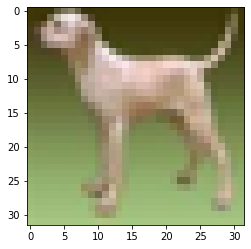

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(train_img[0][0])

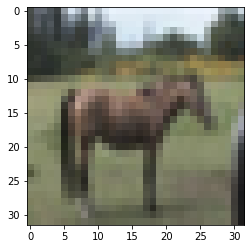

In [19]:
plt.imshow(test_img[0][0])

### 查看数据集的样本的数组形态

In [20]:
x_train.shape

(50000, 32, 32, 3)

### 数据增强处理函数

+ 直方图均衡化

&emsp;&emsp;直方图均衡化通常用来增加许多图像的全局对比度，尤其是当图像的有用数据的对比度相当接近的时候。通过这种方法，亮度可以更好地在直方图上分布。这样就可以用于增强局部的对比度而不影响整体的对比度，直方图均衡化通过有效地扩展常用的亮度来实现这种功能。这种方法对于背景和前景都太亮或者太暗的图像非常有用，这种方法尤其是可以带来X光图像中更好的骨骼结构显示以及曝光过度或者曝光不足照片中更好的细节。这种方法的一个主要优势是它是一个相当直观的技术并且是可逆操作，如果已知均衡化函数，那么就可以恢复原始的直方图，并且计算量也不大。这种方法的一个缺点是它对处理的数据不加选择，它可能会增加背景噪声的对比度并且降低有用信号的对比度。

In [4]:
import shutil
from PIL import Image
import sys
import cv2
from tqdm import notebook
class DataAugumentation(object):
    
    def __init__(self,num=10):
        
        self.num = num

    def CLAHE(self,img):
        grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # 局部直方图均值化
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl1 = clahe.apply(grayimg)
        return cl1

    def Histograms_Equalization(self,img):
        
        grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # 直方图均值化
        equ = cv2.equalizeHist(grayimg)
        return equ

    def make_one_hot(self,data):
        return (np.arange(self.num)==data[:,None]).astype(np.int64)
    
    def augument(self,imgs,labels):
        '''
        使用图像处理方法进行数据增强，直方图均值化和局部直方图均值化
        再加上灰度图和原图片可以将数据集增大三倍
        '''
        x_data,y_data = [],[]
        
        for img,label in notebook.tqdm(zip(imgs,labels),desc='数据增强进度'):
            
            imggray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            x_data.append(imggray.astype('float32') / 255.0)
            y_data.append(label)

            he_image = self.Histograms_Equalization(img)
            x_data.append(he_image.astype('float32') / 255.0)
            y_data.append(label)

            clahe_img = self.CLAHE(img)
            x_data.append(clahe_img.astype('float32') / 255.0)
            y_data.append(label)
            
    
        
        return np.array(x_data),np.array(y_data)

### 处理训练集

In [5]:
da = DataAugumentation()
x_new_train,y_new_train = da.augument(x_train,y_train)
x_new_test,y_new_test = da.augument(x_test,y_test)

+ 扩展数据维度，计算卷积

In [6]:
x_new_train = np.expand_dims(x_new_train, 3)
x_new_test = np.expand_dims(x_new_test,3)

可以看到，数据集增强之后比较大，所以可以把增强后的数据集保存在本地方便再次复用。

In [7]:
pickle.dump(x_new_train, open('./CifaData/x_new_train.p', 'wb'))
pickle.dump(y_new_train, open('./CifaData/y_new_train.p', 'wb'))
pickle.dump(x_new_test, open('./CifaData/x_new_test.p', 'wb'))
pickle.dump(y_new_test, open('./CifaData/y_new_test.p', 'wb'))

In [8]:
!cd CifaData && ls -hl

总用量 705M
-rw-rw-r-- 1 wcjb wcjb 118M 5月  15 09:03 x_new_test.p
-rw-rw-r-- 1 wcjb wcjb 586M 5月  15 09:03 x_new_train.p
-rw-rw-r-- 1 wcjb wcjb 235K 5月  15 09:03 y_new_test.p
-rw-rw-r-- 1 wcjb wcjb 1.2M 5月  15 09:03 y_new_train.p


In [29]:
# with open('./CifaData/y_new_train.p', 'rb') as fo:
#     y_n_train = pickle.load(fo, encoding = 'iso-8859-1')

# 搭建模型

In [22]:
import tensorflow as tf
import datetime

from tensorflow.python.ops import summary_ops_v2
import time

MODEL_DIR = "./models"

class network(tf.keras.Model):
    
    def __init__(self,n_class=10):
        
        super(network,self).__init__()
        
        self.conv2d_01 = tf.keras.layers.Convolution2D (kernel_size = (5, 5),input_shape=(32,32,1), filters = 100, activation='relu')
        self.maxpool2d_01 = tf.keras.layers.MaxPool2D()
        self.conv2d_02 = tf.keras.layers.Convolution2D (kernel_size = (3, 3), filters = 150, activation='relu')
        self.maxpool2d_02 = tf.keras.layers.MaxPool2D()
        self.conv2d_03 = tf.keras.layers.Convolution2D (kernel_size = (3, 3), filters = 250, padding='same', activation='relu')
        self.maxpool2d_03 = tf.keras.layers.MaxPool2D()
        self.flatten = tf.keras.layers.Flatten()
        self.dense_01 = tf.keras.layers.Dense(512, activation='relu')
        self.dense_02 = tf.keras.layers.Dense(300, activation='relu')
        self.dense_03 = tf.keras.layers.Dense(10,activation='softmax') 
        self.optimizer = tf.optimizers.Adam(learning_rate=1e-4)

        if not tf.io.gfile.exists(MODEL_DIR):
            tf.io.gfile.makedirs(MODEL_DIR)
        
        train_dir = os.path.join(MODEL_DIR, 'summaries', 'train')
        test_dir = os.path.join(MODEL_DIR, 'summaries', 'eval')

        self.train_summary_writer = summary_ops_v2.create_file_writer(train_dir, flush_millis=10000)
        self.test_summary_writer = summary_ops_v2.create_file_writer(test_dir, flush_millis=10000, name='test')
        
        checkpoint_dir = os.path.join(MODEL_DIR, 'checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
        self.checkpoint = tf.train.Checkpoint(model=self, optimizer=self.optimizer)  

        # 如果存在检查点，则在创建时还原变量
        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
        
    def call(self,inputs):
        
        x = self.conv2d_01(inputs)
        x = self.maxpool2d_01(x)
        
        x = self.conv2d_02(x)
        x = self.maxpool2d_02(x)
        
        x = self.conv2d_03(x)
        x = self.maxpool2d_03(x)
        
        x = self.flatten(x)
      
        x = self.dense_01(x)
        x = self.dense_02(x)
        x = self.dense_03(x)
        
        return x
        
    @tf.function()
    def compute_loss(self, logits, labels):
        return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True))

    @tf.function()
    def compute_accuracy(self, logits, labels):
        return tf.keras.metrics.sparse_categorical_accuracy(labels, logits)
    
    @tf.function(experimental_relax_shapes=True)
    def train_step(self, images, labels):
        
        with tf.device('/GPU:0'):
            with tf.GradientTape() as tape:
                logits = self.call(images)
                loss = self.compute_loss(logits, labels)
                accuracy = self.compute_accuracy(logits, labels)
            grads = tape.gradient(loss, self.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return loss, accuracy, logits

    def training(self, train_dataset, test_dataset, epochs=1, log_freq=50):

        for i in range(epochs):
            train_start = time.time()
            with self.train_summary_writer.as_default():
                start = time.time()
                # Metrics are stateful. They accumulate values and return a cumulative
                # result when you call .result(). Clear accumulated values with .reset_states()
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)  
                avg_accuracy = tf.keras.metrics.Mean('accuracy', dtype=tf.float32)  

                # Datasets can be iterated over like any other Python iterable.
                for images, labels in train_dataset:
                    
                    loss, accuracy, logits = self.train_step(images, labels)
                    avg_loss(loss)
                    avg_accuracy(accuracy)

                    if tf.equal(self.optimizer.iterations % log_freq, 0):
                        summary_ops_v2.scalar('loss', avg_loss.result(), step=self.optimizer.iterations)
                        summary_ops_v2.scalar('accuracy', avg_accuracy.result(), step=self.optimizer.iterations)
                        
                        rate = log_freq / (time.time() - start)
                        print('Step #{}\tLoss: {:0.6f} accuracy: {:0.2f}% ({} steps/sec)'.format(self.optimizer.iterations.numpy(), loss, (avg_accuracy.result() * 100), rate))
                        avg_loss.reset_states()
                        avg_accuracy.reset_states()
                        start = time.time()

            train_end = time.time()
            print('\nTrain time for epoch #{} ({} total steps): {}'.format(i + 1, self.optimizer.iterations.numpy(), train_end - train_start))
            with self.test_summary_writer.as_default():
                self.testing(test_dataset, self.optimizer.iterations)
            self.checkpoint.save(self.checkpoint_prefix)
        self.export_path = os.path.join(MODEL_DIR, 'export')
        #tf.saved_model.save(self, self.export_path)
        
    
    def testing(self, test_dataset, step_num):
        """Perform an evaluation of `model` on the examples from `dataset`."""
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
        avg_accuracy = tf.keras.metrics.Mean('accuracy', dtype=tf.float32)

        for (images, labels) in test_dataset:
            logits = self.call(images)
            avg_loss(self.compute_loss(logits, labels))
            avg_accuracy(self.compute_accuracy(logits, labels))

        print('Model test set loss: {:0.4f} accuracy: {:0.2f}%'.format(avg_loss.result(), avg_accuracy.result() * 100))
        summary_ops_v2.scalar('loss', avg_loss.result(), step=step_num)
        summary_ops_v2.scalar('accuracy', avg_accuracy.result(), step=step_num)
            
    def evaluating(self, test_dataset):
#         restored_model = tf.saved_model.restore(self.export_path)
#         y_predict = restored_model(x_test)
        avg_accuracy = tf.keras.metrics.Mean('accuracy', dtype=tf.float32)

        for (images, labels) in test_dataset:
            logits = self.call(images)
            avg_accuracy(self.compute_accuracy(logits, labels))

        print('Model accuracy: {:0.2f}%'.format(avg_accuracy.result() * 100))

    def forward(self, xs):  
        predictions = self.model(xs)
        logits = tf.nn.softmax(predictions)

        return logits
    

In [28]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_new_test.astype(np.float32), y_new_test))
val_dataset = val_dataset.shuffle(10000).batch(640)

dataset = tf.data.Dataset.from_tensor_slices((x_new_train.astype(np.float32), y_new_train))
dataset = dataset.shuffle(1000).batch(640)  # .shuffle(len(train_xs))
        

In [30]:
net = network()
net.training(dataset, val_dataset)
# 需要注意的是save_model不能在tf.function装饰的函数内执行

#tf.keras.models.save_model(net,net.export_path)

Step #37750	Loss: 1.635083 accuracy: 80.03% (47.73610244877334 steps/sec)
Step #37800	Loss: 1.662184 accuracy: 79.86% (23.883972169046178 steps/sec)
Step #37850	Loss: 1.651432 accuracy: 79.77% (23.889010837671186 steps/sec)
Step #37900	Loss: 1.666890 accuracy: 80.96% (24.054509509387806 steps/sec)
Step #37950	Loss: 1.649743 accuracy: 81.50% (23.856509118566446 steps/sec)

Train time for epoch #1 (37974 total steps): 10.556878089904785
Model test set loss: 1.7757 accuracy: 68.37%


In [32]:
!cd models/checkpoints/ && ls -lh

总用量 368M
-rw-rw-r-- 1 wcjb wcjb   71 5月  15 09:26 checkpoint
-rw-rw-r-- 1 wcjb wcjb 5.0K 5月  15 07:21 ckpt-10.data-00000-of-00002
-rw-rw-r-- 1 wcjb wcjb  21M 5月  15 07:21 ckpt-10.data-00001-of-00002
-rw-rw-r-- 1 wcjb wcjb 3.0K 5月  15 07:21 ckpt-10.index
-rw-rw-r-- 1 wcjb wcjb 5.0K 5月  15 09:04 ckpt-11.data-00000-of-00002
-rw-rw-r-- 1 wcjb wcjb  21M 5月  15 09:04 ckpt-11.data-00001-of-00002
-rw-rw-r-- 1 wcjb wcjb 3.0K 5月  15 09:04 ckpt-11.index
-rw-rw-r-- 1 wcjb wcjb 5.0K 5月  15 09:08 ckpt-12.data-00000-of-00002
-rw-rw-r-- 1 wcjb wcjb  21M 5月  15 09:08 ckpt-12.data-00001-of-00002
-rw-rw-r-- 1 wcjb wcjb 3.0K 5月  15 09:08 ckpt-12.index
-rw-rw-r-- 1 wcjb wcjb 5.0K 5月  15 09:15 ckpt-13.data-00000-of-00002
-rw-rw-r-- 1 wcjb wcjb  21M 5月  15 09:15 ckpt-13.data-00001-of-00002
-rw-rw-r-- 1 wcjb wcjb 3.0K 5月  15 09:15 ckpt-13.index
-rw-rw-r-- 1 wcjb wcjb 5.0K 5月  15 09:17 ckpt-14.data-00000-of-00002
-rw-rw-r-- 1 wcjb wcjb  21M 5月  15 09:17 ckpt-14.data-00001-of-00002
-rw-rw-r-- 1 wcjb wcjb 3.0K 5

GPU tf.float32 24.5s

CPU tf.float32 4min30s

GPU tf.float16 21.9